# 6.0 - Pitch Movement and Effectiveness, Fastballs
Modeling fastball effectiveness.

## Libraries

In [4]:
import logging
import sys
import warnings

import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    log_loss
)

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from pygam import (
    GAM,
    LogisticGAM,
    s,
    f,
    te
)

## Setup

In [2]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [4]:
# BigQuery
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [5]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

## Data

In [6]:
params = {
    'min_year': 2016
}

In [7]:
SQL = \
"""
SELECT
  t_events.pitcher_id AS pitcher_id,
  t_events.batter_id AS batter_id,
  t_pitcher.pitcher_name AS pitcher_name,
  t_batter.batter_name AS batter_name,
  t_events.pitcher_hand AS pitcher_hand,
  t_events.batter_hand AS batter_hand,
  t_events.same_hand AS same_hand,
  t_events.release_speed AS release_speed,
  t_events.release_spin_rate AS release_spin_rate,
  t_events.horizontal_movement AS horizontal_movement,
  t_events.vertical_movement AS vertical_movement,
  t_events.horizontal_location AS horizontal_location,
  t_events.vertical_location AS vertical_location,
  t_events.outcome AS outcome
FROM
  (
    SELECT
      pitcher AS pitcher_id,
      batter AS batter_id,
      p_throws AS pitcher_hand,
      stand AS batter_hand,
      (CASE WHEN p_throws = stand THEN 1 ELSE 0 END) AS same_hand,
      release_speed,
      release_spin_rate,
      pfx_x AS horizontal_movement,
      pfx_z AS vertical_movement,
      plate_x AS horizontal_location,
      plate_z AS vertical_location,
      description AS outcome
    FROM
      `ad-fantasy-baseball.core.statcast`
    WHERE
      game_type = 'R'
        AND game_year >= {min_year}
        AND pitch_type = 'FF'
  ) t_events
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id AS pitcher_id,
      MAX(mlb_name) AS pitcher_name
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1
  ) t_pitcher
    ON (t_events.pitcher_id = t_pitcher.pitcher_id)
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id AS batter_id,
      MAX(mlb_name) AS batter_name
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1
  ) t_batter
    ON (t_events.batter_id = t_batter.batter_id)
"""

In [8]:
sql_base = SQL.format(**params)
df_base = read_gbq(query=sql_base, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_copy = df_base.copy()

Requesting query... 
ok.
Query running...
Job ID: 4a8b5d61-62f9-414f-b584-1a9a3206660d
Query running...
Got 770487 rows.

Total time taken 116.56 s.
Finished at 2019-04-01 18:54:59.


In [9]:
df_base.head()

,pitcher_id,batter_id,pitcher_name,batter_name,pitcher_hand,batter_hand,same_hand,release_speed,release_spin_rate,horizontal_movement,vertical_movement,horizontal_location,vertical_location,outcome
0,477569,435622,Fernando Salas,Ian Desmond,R,R,1,90.1,2083,-0.1884,1.4974,-0.4518,3.0396,hit_into_play
1,477569,467827,Fernando Salas,Gerardo Parra,R,L,0,90.5,2066,-0.3706,1.5868,-0.0446,3.3269,hit_into_play
2,592662,622608,Robbie Ray,Antonio Senzatela,L,R,0,90,2234,0.6399,1.4106,0.1113,2.7073,hit_into_play_no_out
3,425844,596115,Zack Greinke,Trevor Story,R,R,1,90,2339,-0.3047,1.5127,0.0042,2.8313,hit_into_play
4,477569,518735,Fernando Salas,Yasmani Grandal,R,L,0,90.2,2291,-0.462,1.649,0.635,2.8983,hit_into_play


In [10]:
df_base.shape

(770487, 14)

## Data Prep

In [11]:
numeric_cols = [
    'release_speed',
    'release_spin_rate',
    'horizontal_movement',
    'vertical_movement',
    'horizontal_location',
    'vertical_location'
]

df_base[numeric_cols] = df_base[numeric_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [12]:
# Outcome filters
outcomes_strike = [
    'called_strike',
    'swinging_strike',
    'swinging_strike_blocked',
    'missed_bunt'
]
outcomes_ball = [
    'ball',
    'blocked_ball',
    'pitchout',
    'hit_by_pitch'
]
outcomes_contact = [
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip',
    'foul_bunt'
]
outcomes_swing = [
    'swinging_strike',
    'swinging_strike_blocked',
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip'
]

_pitcher_r = df_base['pitcher_hand'] == 'R'
_batter_r = df_base['batter_hand'] == 'R'
_strike = df_base['outcome'].isin(outcomes_strike)
_ball = df_base['outcome'].isin(outcomes_ball)
_contact = df_base['outcome'].isin(outcomes_contact)
_swing = df_base['outcome'].isin(outcomes_swing)

In [13]:
# Data filters
_speed = df_base['release_speed'] > 82
_spin = (df_base['release_spin_rate'] > 1500) & (df_base['release_spin_rate'] < 3000)
_h_mov = (df_base['horizontal_movement'] > -2) & (df_base['horizontal_movement'] < 2)
_v_mov = (df_base['vertical_movement'] > 0) & (df_base['vertical_movement'] < 2.5)
_h_loc = (df_base['horizontal_location'] > -2) & (df_base['horizontal_location'] < 2)
_v_loc = (df_base['vertical_location'] > 0.5) & (df_base['vertical_location'] < 4.5)

_data = _speed & _spin & _h_mov & _v_mov & _h_loc & _v_loc

In [14]:
df_core = df_base[_swing & _data].copy()

df_core['horizontal_movement_adj'] = np.where(
    df_core['pitcher_hand'] == 'R',
    df_core['horizontal_movement'],
    -df_core['horizontal_movement']
)
df_core['horizontal_location_adj'] = np.where(
    df_core['batter_hand'] == 'R',
    df_core['horizontal_location'],
    -df_core['horizontal_location']
)

df_core['flag_strike'] = np.where(df_core['outcome'].isin(outcomes_strike), 1, 0)
df_core['flag_contact'] = np.where(df_core['outcome'].isin(outcomes_contact), 1, 0)
df_core['flag_swstr'] = np.where(df_core['outcome'] == 'swinging_strike', 1, 0)

In [15]:
df_core.head()

,pitcher_id,batter_id,pitcher_name,batter_name,pitcher_hand,batter_hand,same_hand,release_speed,release_spin_rate,horizontal_movement,vertical_movement,horizontal_location,vertical_location,outcome,horizontal_movement_adj,horizontal_location_adj,flag_strike,flag_contact,flag_swstr
0,477569,435622,Fernando Salas,Ian Desmond,R,R,1,90.1,2083.0,-0.1884,1.4974,-0.4518,3.0396,hit_into_play,-0.1884,-0.4518,0,1,0
1,477569,467827,Fernando Salas,Gerardo Parra,R,L,0,90.5,2066.0,-0.3706,1.5868,-0.0446,3.3269,hit_into_play,-0.3706,0.0446,0,1,0
2,592662,622608,Robbie Ray,Antonio Senzatela,L,R,0,90.0,2234.0,0.6399,1.4106,0.1113,2.7073,hit_into_play_no_out,-0.6399,0.1113,0,1,0
3,425844,596115,Zack Greinke,Trevor Story,R,R,1,90.0,2339.0,-0.3047,1.5127,0.0042,2.8313,hit_into_play,-0.3047,0.0042,0,1,0
4,477569,518735,Fernando Salas,Yasmani Grandal,R,L,0,90.2,2291.0,-0.4620,1.6490,0.6350,2.8983,hit_into_play,-0.4620,-0.6350,0,1,0


## Analysis

In [16]:
key_features = [
    'release_speed',
    'release_spin_rate',
    'horizontal_movement_adj',
    'vertical_movement',
    'horizontal_location_adj',
    'vertical_location'
]

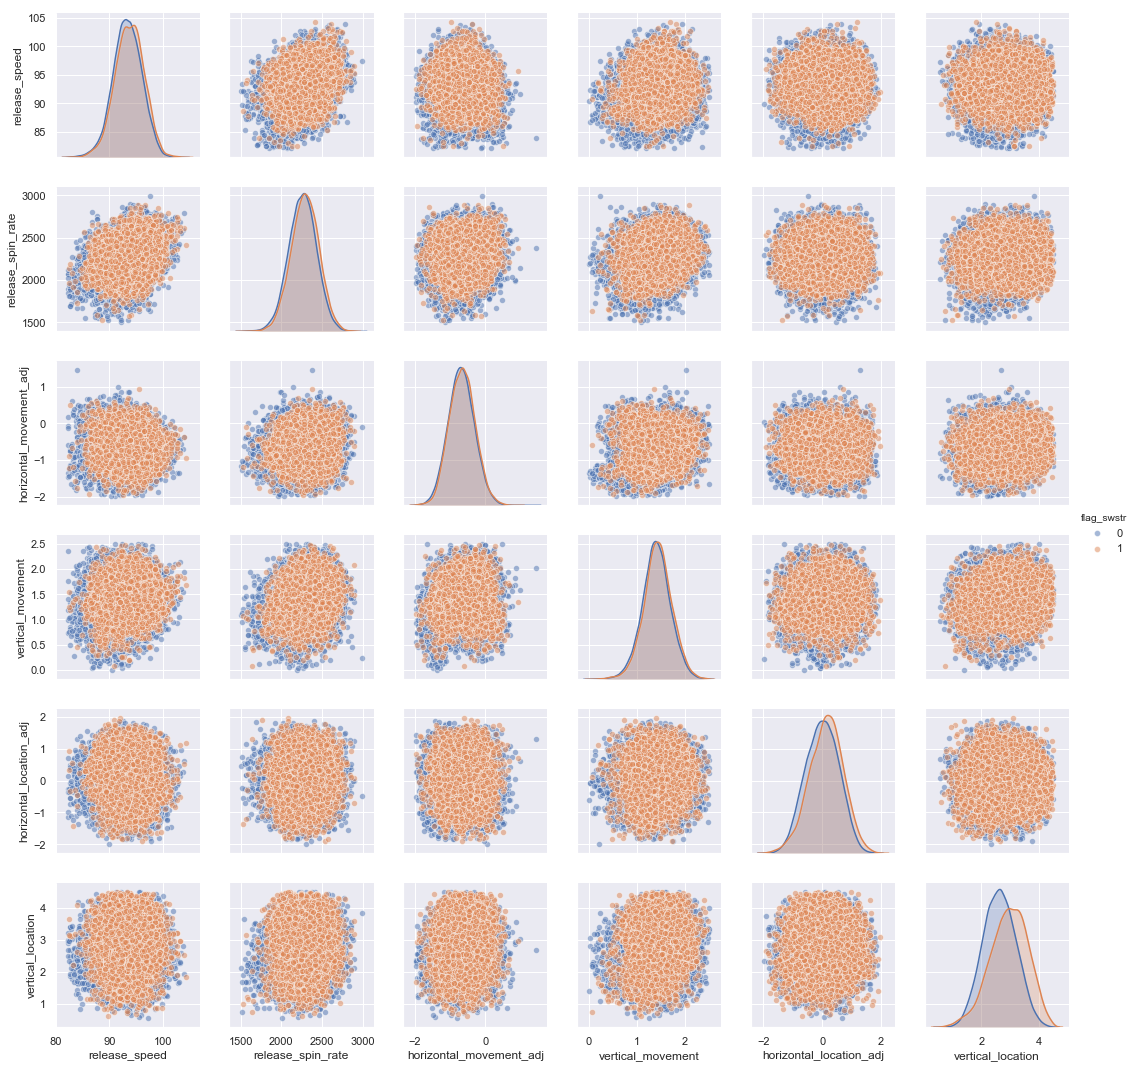

In [17]:
sns.pairplot(
    data=df_core.sample(n=50000),
    vars=key_features,
    hue='flag_swstr',
    plot_kws={'alpha': 0.5}
)

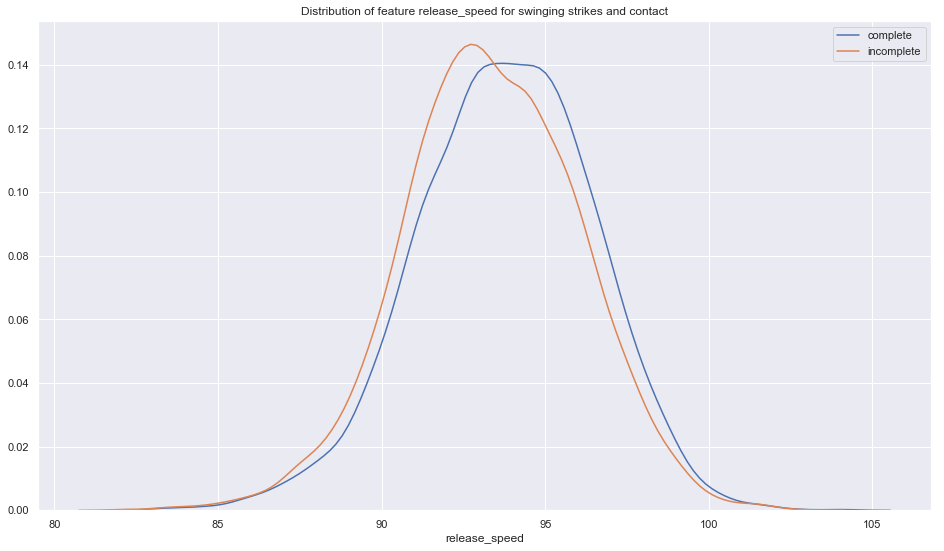

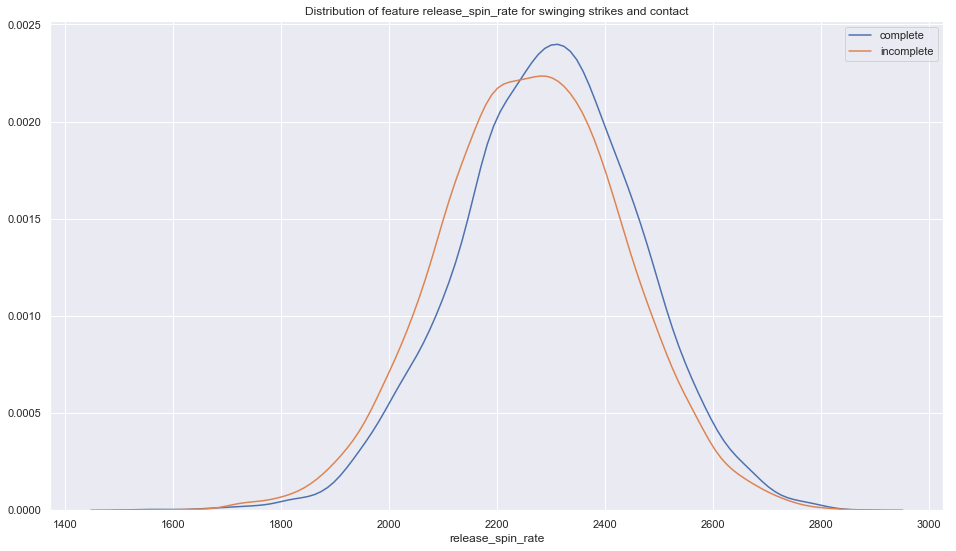

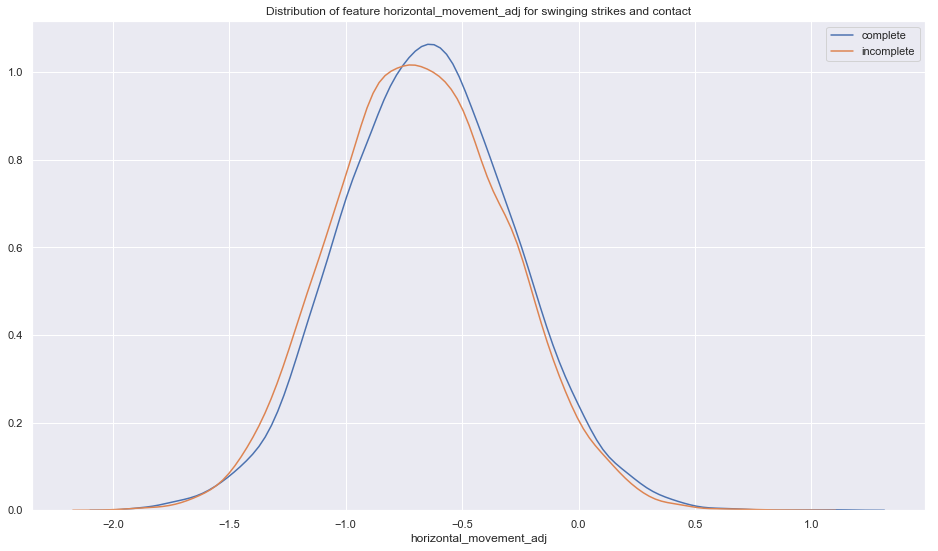

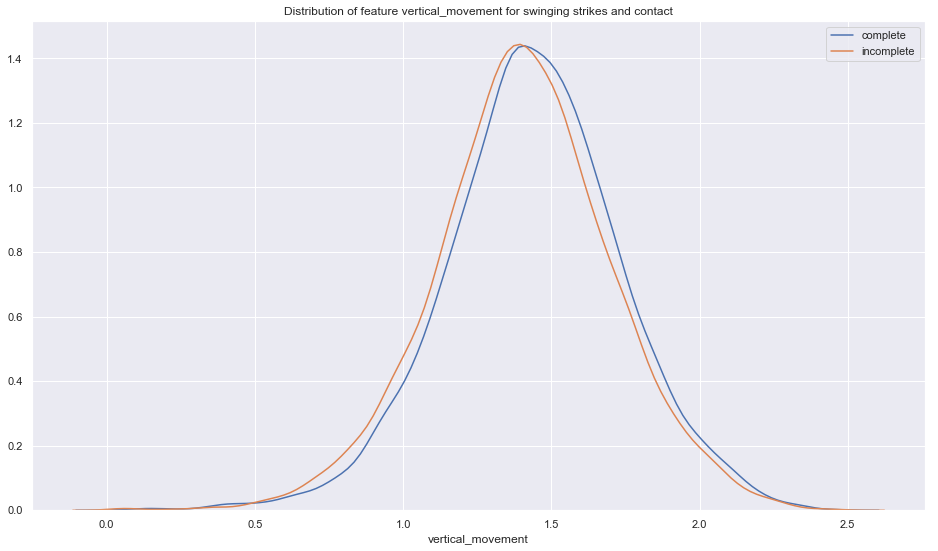

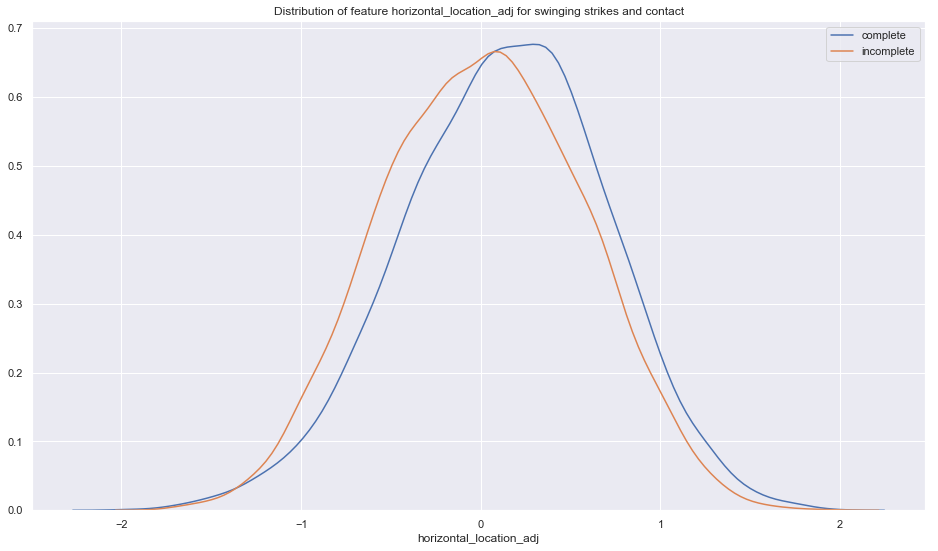

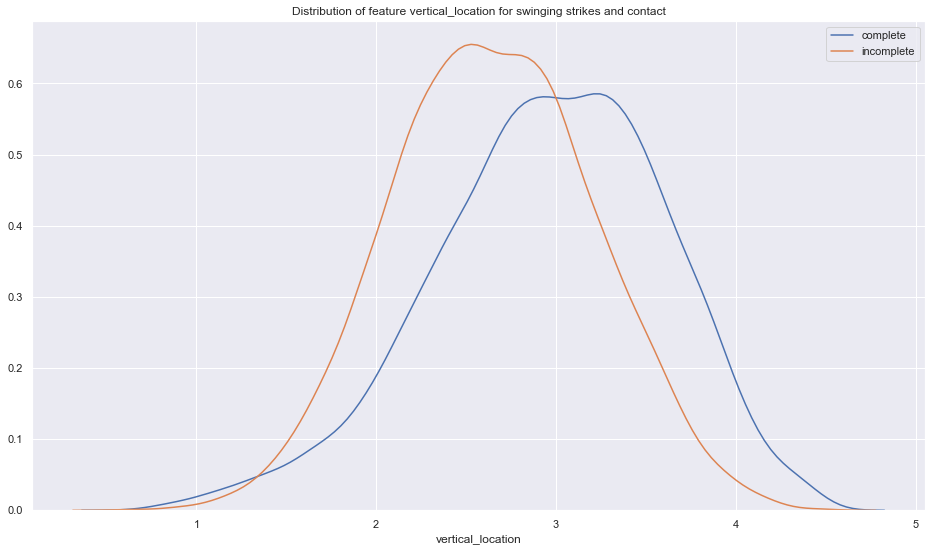

In [18]:
for feature in key_features:
    swstr_data = df_core[df_core['flag_swstr'] == 1][feature].sample(n=10000)
    contact_data = df_core[df_core['flag_swstr'] == 0][feature].sample(n=10000)
    
    sns.distplot(a=swstr_data, label='complete', hist=False)
    sns.distplot(a=contact_data, label='incomplete', hist=False)

    plt.title('Distribution of feature {:s} for swinging strikes and contact'.format(feature))
    plt.show()

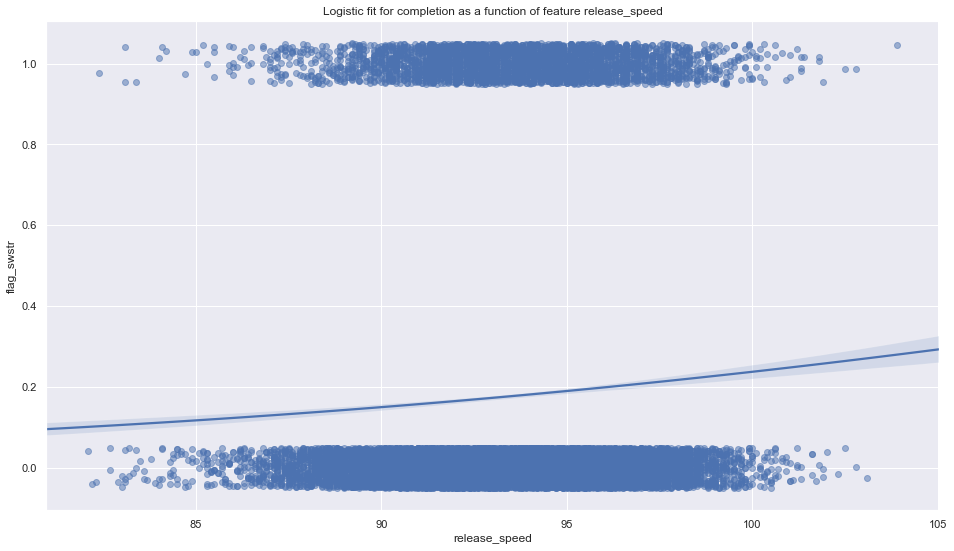

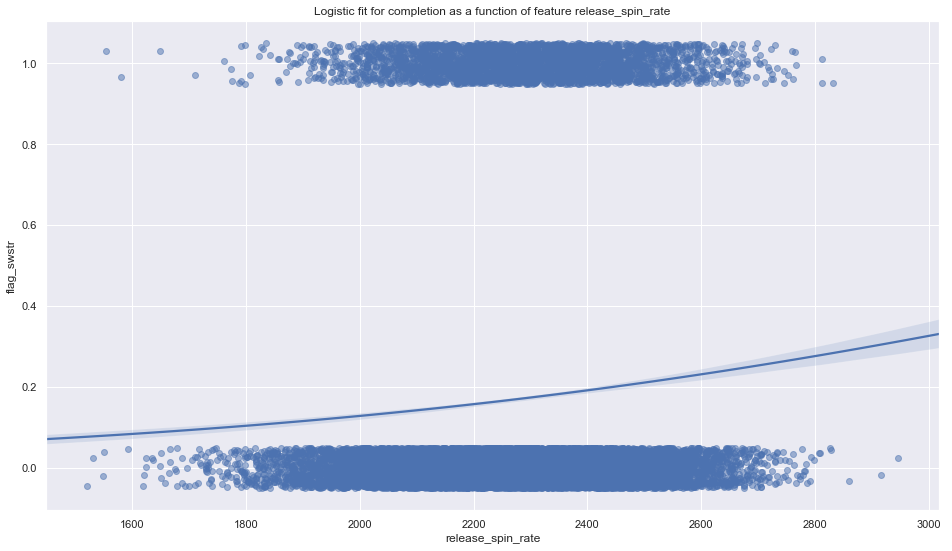

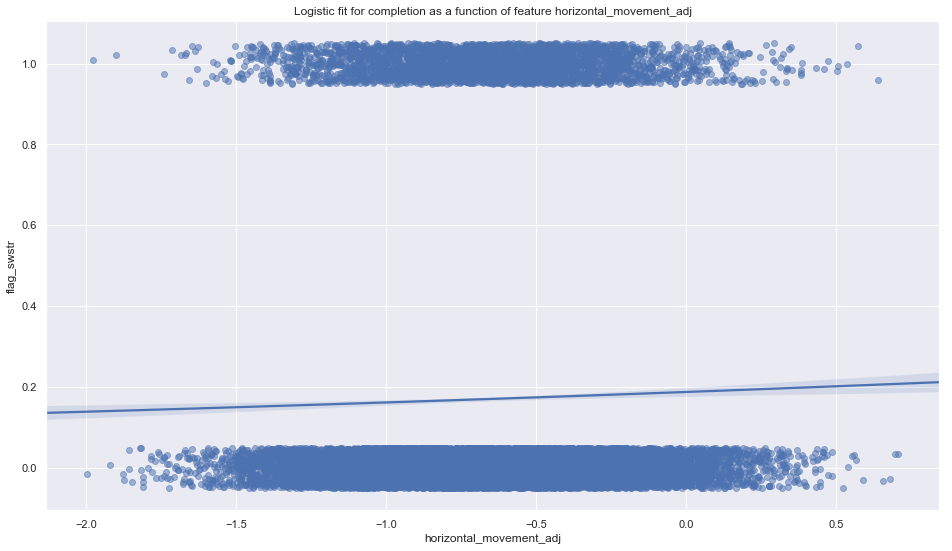

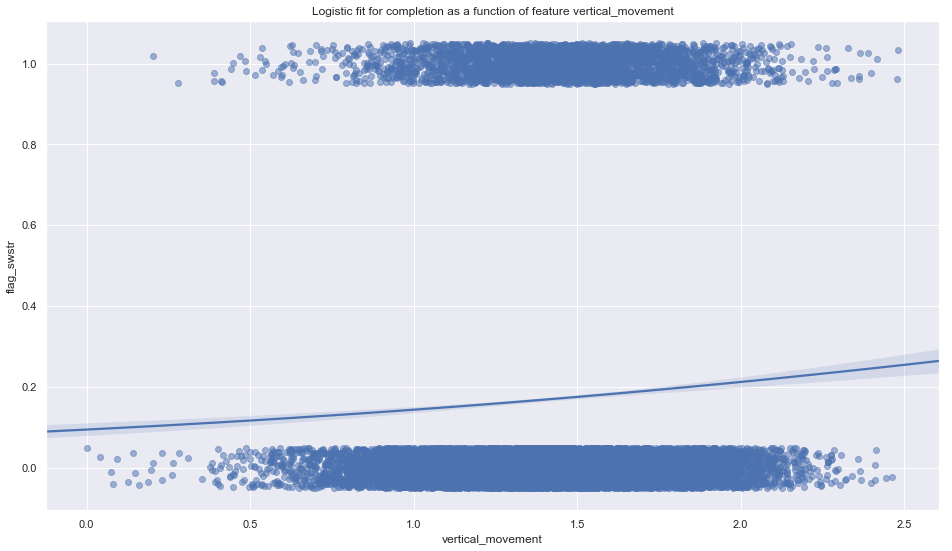

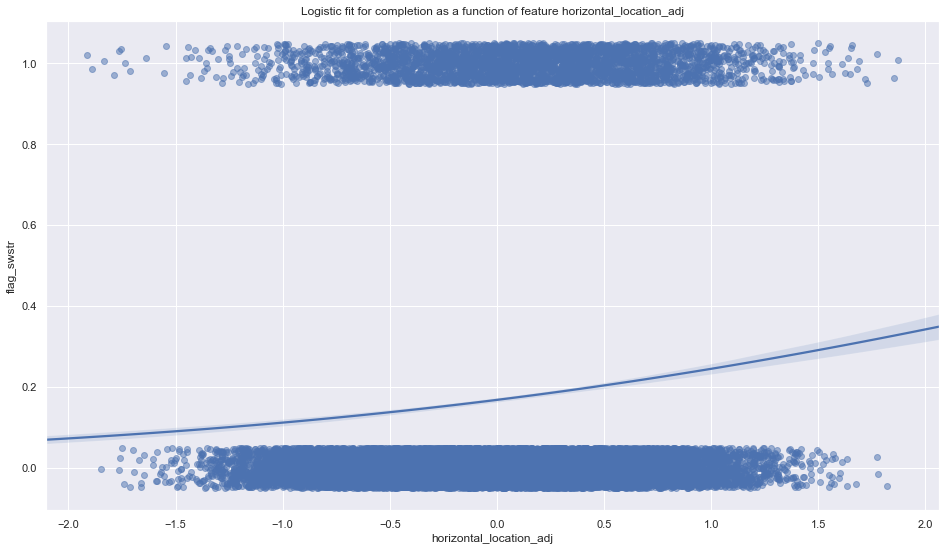

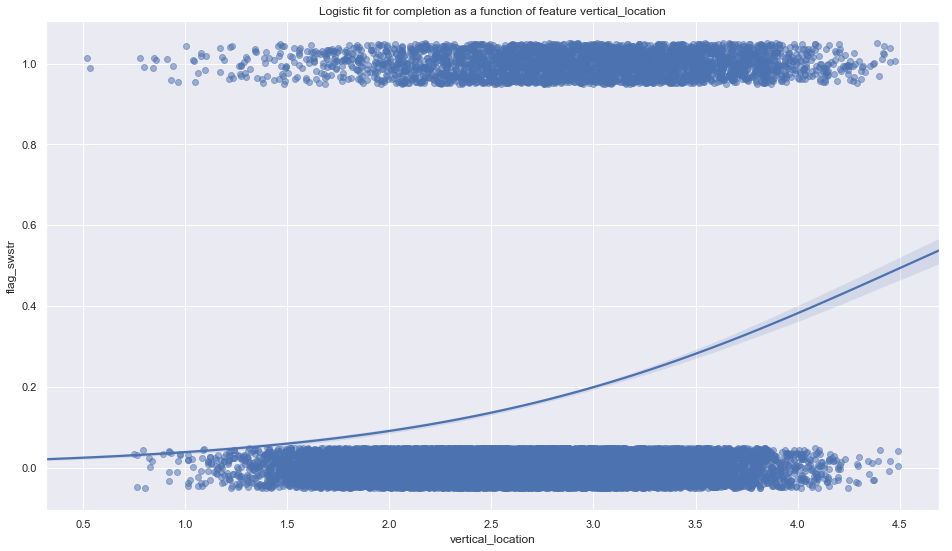

In [19]:
for feature in key_features:    
    sns.regplot(
        data=df_core.sample(n=20000),
        x=feature,
        y='flag_swstr',
        logistic=True,
        y_jitter=0.05,
        scatter_kws={'alpha': 0.5}
    )

    plt.title('Logistic fit for completion as a function of feature {:s}'.format(feature))
    plt.show()

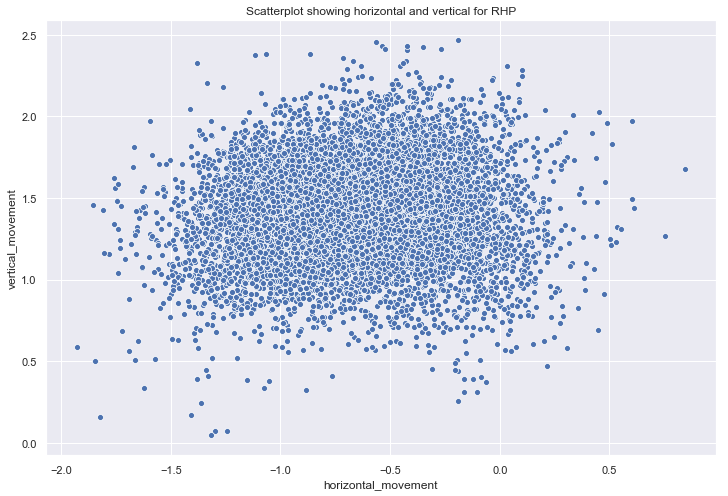

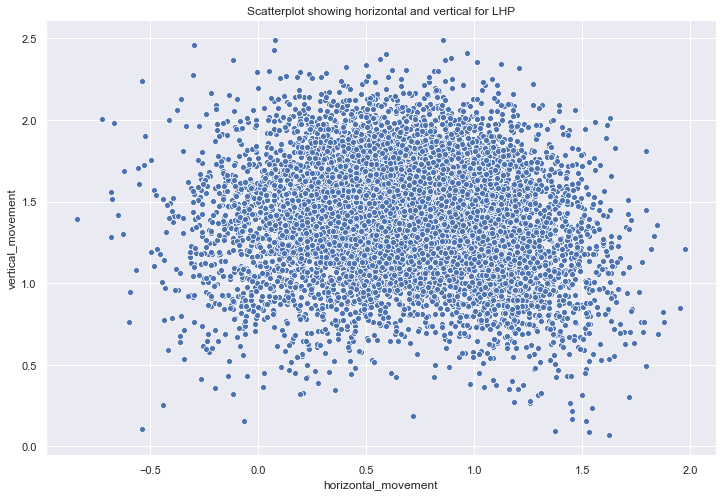

In [41]:
for pitcher_hand in ['R', 'L']:
    _data = df_core[df_core['pitcher_hand'] == pitcher_hand].sample(n=10000)

    sns.scatterplot(
        data=_data,
        x='horizontal_movement',
        y='vertical_movement'
    )

    plt.title('Scatterplot showing horizontal and vertical for {:s}HP'.format(pitcher_hand))
    plt.show()

## Modeling

### GAMs

In [24]:
def train_and_evaluate_gam(
        df,
        label,
        features,
        classes,
        model=None,
        constraints=None,
        lam=None,
        intercept=True,
        n_splines=10,
        resampler=None,
        test_size=0.2,
        decision_threshold=0.5
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')

    # Handle None inputs
    if constraints is None:
        constraints = [None] * len(features)
        
    if lam is None:
        lam = np.logspace(-3, 3, 11)
    
    # Define X and y arrays
    X = _df[features].values
    y = _df[label].values
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, stratify=y)
        
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
                
    # Train the model
    if model is None:
        model = LogisticGAM(n_splines=n_splines, fit_intercept=intercept)
    
    model.gridsearch(
        X_res,
        y_res,
        return_scores=True,
        constraints=constraints,
        lam=lam
    )

    num_terms = [ term for i, term in enumerate(model.terms) if not (term.istensor or term.isintercept) ]
    ten_terms = [ term for i, term in enumerate(model.terms) if term.istensor ]
    
    # Print GAM summary
    model.summary()
    
    # Plot individual features
    # Spline and factor terms
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(num_terms))
    ax_idx = 0
        
    for i, term in enumerate(model.terms):
        if term.isintercept or term.istensor:
            continue
            
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.9)

        if len(num_terms) > 1:
            ax = axs[ax_idx]
            ax_idx += 1
        else:
            ax = axs

        ax.plot(XX[:, term.feature], pdep)
        ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_title(term.feature)

    plt.show()
    
    # Tensor terms
    plt.rcParams['figure.figsize'] = (12, 8)
    
    for i, term in enumerate(model.terms):
        if not term.istensor:
            continue

        XX = model.generate_X_grid(term=i, meshgrid=True)
        Z = model.partial_dependence(term=i, X=XX, meshgrid=True)

        ax = plt.axes(projection='3d')
        ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
        plt.show()

    # Test the model against the held over test set
    y_pred_proba = model.predict_proba(X_test)
    y_pred = y_pred_proba > decision_threshold
    
    # Model metrics
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nPrecision Score: {:3.3f}".format(precision_score(y_test, y_pred)))

    print("\nRecall Score: {:3.3f}".format(recall_score(y_test, y_pred)))

    print("\nF1 Score: {:3.3f}".format(f1_score(y_test, y_pred)))

    print("\nROC AUC Score: {:3.3f}".format(roc_auc_score(y_test, y_pred_proba)))

    print("\nAccuracy: {:3.3f}".format(accuracy_score(y_test, y_pred)))

    print("\nLog Loss: {:3.3f}".format(log_loss(y_test, y_pred_proba)))
    
    return model

100% (15 of 15) |########################| Elapsed Time: 0:00:46 Time:  0:00:46
/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     14.1371
Link Function:                        LogitLink Log Likelihood:                               -128912.8302
Number of Samples:                       282910 AIC:                                           257853.9346
                                                AICc:                                          257853.9364
                                                UBRE:                                               2.9115
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.009
Feature Function                  Lam

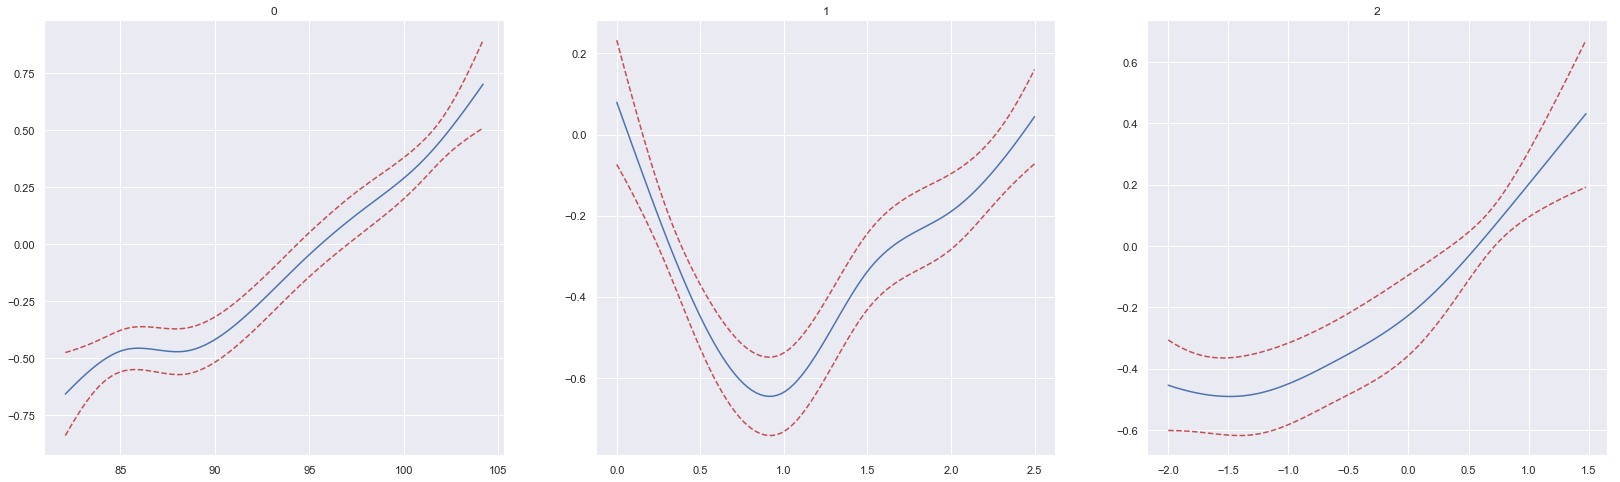


Confusion Matrix:
[[47013 11515]
 [ 8863  3337]]

Precision Score: 0.225

Recall Score: 0.274

F1 Score: 0.247

ROC AUC Score: 0.570

Accuracy: 0.712

Log Loss: 0.455


In [38]:
gam_label_simple = 'flag_swstr'
gam_classes_simple = ['contact', 'swinging_strike']
gam_features_simple = [
    'release_speed',
    'vertical_movement',
    'horizontal_movement_adj'
]
gam_constraints_simple = [None, None, None]
gam_lam_simple = np.logspace(-2, 2, 5)
gam_model_simple = LogisticGAM(
    s(0, n_splines=10) +
    s(1, n_splines=8) +
    s(2, n_splines=8)
)

whiff_gam_simple = train_and_evaluate_gam(
    df=df_core,
    label=gam_label_simple,
    features=gam_features_simple,
    classes=gam_classes_simple,
    model=gam_model_simple,
    lam=gam_lam_simple,
    intercept=True,
    test_size=0.2,
    decision_threshold=0.2
)

100% (15 of 15) |########################| Elapsed Time: 0:06:53 Time:  0:06:53
/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     54.4646
Link Function:                        LogitLink Log Likelihood:                               -119372.2179
Number of Samples:                       282910 AIC:                                           238853.3651
                                                AICc:                                          238853.3872
                                                UBRE:                                               2.8444
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0823
Feature Function                  Lam

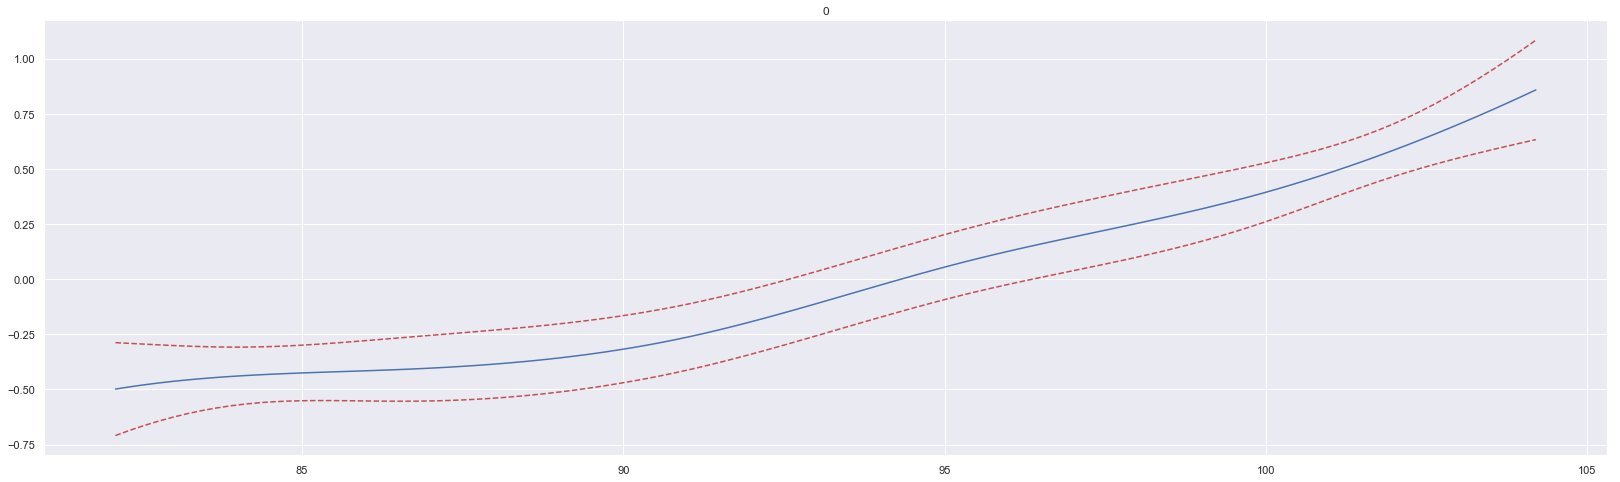

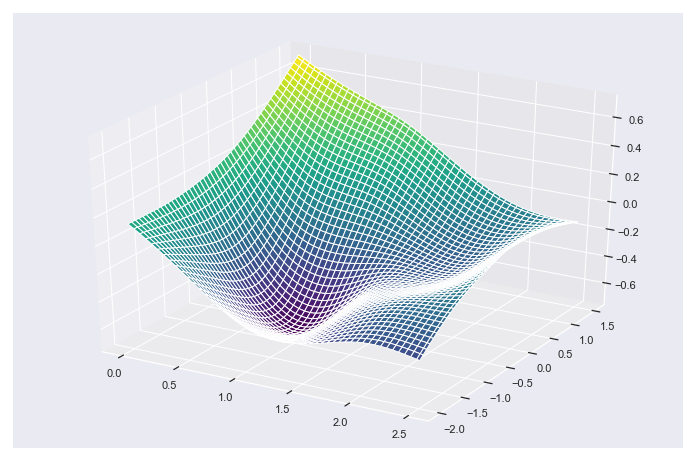

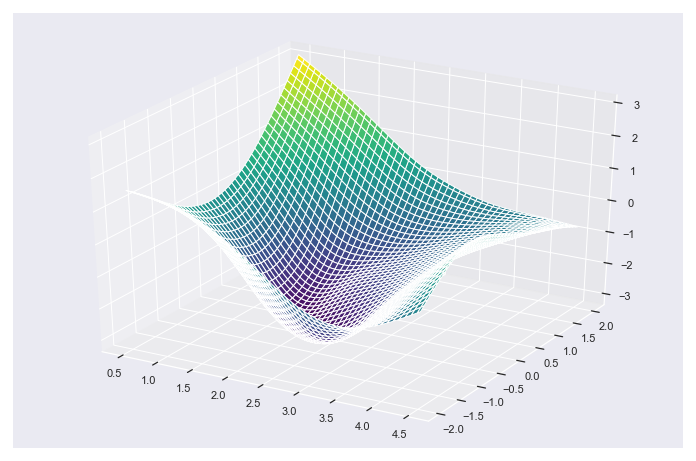


Confusion Matrix:
[[43021 15507]
 [ 5440  6760]]

Precision Score: 0.304

Recall Score: 0.554

F1 Score: 0.392

ROC AUC Score: 0.705

Accuracy: 0.704

Log Loss: 0.420


In [40]:
gam_label_loc = 'flag_swstr'
gam_classes_loc = ['contact', 'swinging_strike']
gam_features_loc = [
    'release_speed',
    'vertical_movement',
    'horizontal_movement_adj',
    'vertical_location',
    'horizontal_location_adj'
]
gam_constraints_loc = [None, None, None]
gam_lam_loc = np.logspace(-1, 1, 3)
gam_model_loc = LogisticGAM(
    s(0, n_splines=8) +
    te(1, 2, n_splines=8) +
    te(3, 4, n_splines=10)
)

whiff_gam_loc = train_and_evaluate_gam(
    df=df_core,
    label=gam_label_loc,
    features=gam_features_loc,
    classes=gam_classes_loc,
    model=gam_model_loc,
    lam=gam_lam_loc,
    intercept=True,
    test_size=0.2,
    decision_threshold=0.2
)